In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import pandas as pd
# pd.options.display.max_rows = 999
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

- In this exercise, we are going to use another python library, namely <a href='https://github.com/ray-project/tune-sklearn'>tune-sklearn</a>, for hyperparameter tuning.
- Tune-sklearn is specialised in model selection, equipped with basic tunning methods (GridSearchCV, RandomizedSearchCV) and more advanced opitmization techniques such as <a href='https://en.wikipedia.org/wiki/Bayesian_optimization'>Bayesian Optimization</a>, <a href='https://arxiv.org/abs/1603.06560'>HyperBand</a> and <a href='https://www.automl.org/blog_bohb/'>BOHB</a>.
- It supports sklearn models and other classifiers using sklearn wrappers.


In [2]:
# install the three packages in the terminal
# conda install -c conda-forge tune-sklearn
# conda install -c conda-forge ray-tune
# conda install -c conda-forge scikit-optimize

# Create a toy dataset
- Using sklearn make_classification to create a dataset X, y with 100000 samples, 50 features, 50 infomative features, 0 redundant feature, 3 classes, set random state to 42.

In [3]:
# generate toy dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=50, n_informative=50, n_redundant=0, n_classes=3, random_state=42)

# Use grid search cv in tune-sklearn
- We will use <a href='https://scikit-learn.org/stable/modules/sgd.html'>stochastic gradient descent</a> classifier here, because it is a gradient descent method which feeds one training data to the model at each iteration to adjust the weight. This method give high efficieny in training huge data.
- Import SGDClassifier() from sklearn, which is our optimization method, we will use linear SVM model.
- Define a dictionary <b>params</b> which contains hyperparameter choices, we will use two parameters here:
     1. loss: hinge, <a href='https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/squared-hinge'>squared_hinge</a>
     2. alpha (learning rate): 1e-4, 1e-1, 1
     3. <a href='https://www.researchgate.net/profile/Moacyr-Araujo/publication/253804636/figure/fig2/AS:393237924728839@1470766635380/Vapniks-e-insensitive-loss-function.png'>epsilon (epsilon-intensive hinge loss for soft margin, tolerence of error with $\epsilon$ distance within the two margins)</a>: 0.01, 0.1
  <br><br>
- Use <a href='https://docs.ray.io/en/master/tune/api_docs/sklearn.html'>TuneGridSearchCV</a> of tune-sklearn for grid search, set <b>estimator</b> to be SGDClassifier(), use params as <b>param_grid</b>, validate using 5-fold <b>cv</b>, set <b>early stopping</b>to True, <b>max number of iteration</b> to 10, <b>n_jobs</b> to -1 to use all processors.
- Loss='hinge' means that we are using support vector machine as mdeol
- Early stopping allows SGD to stop when the validation score is not improving, maximun number of iterations limits the number epoches (actually epoch and iteration are two different terms, but the Ray library overlaps two in its documentation).
- Fit TuneGridSearchCV with X, y
- Print the best score and best parameters of grid search result using property <b>best_score</b> and <b>best_params_</b> of TuneGridSearchCV

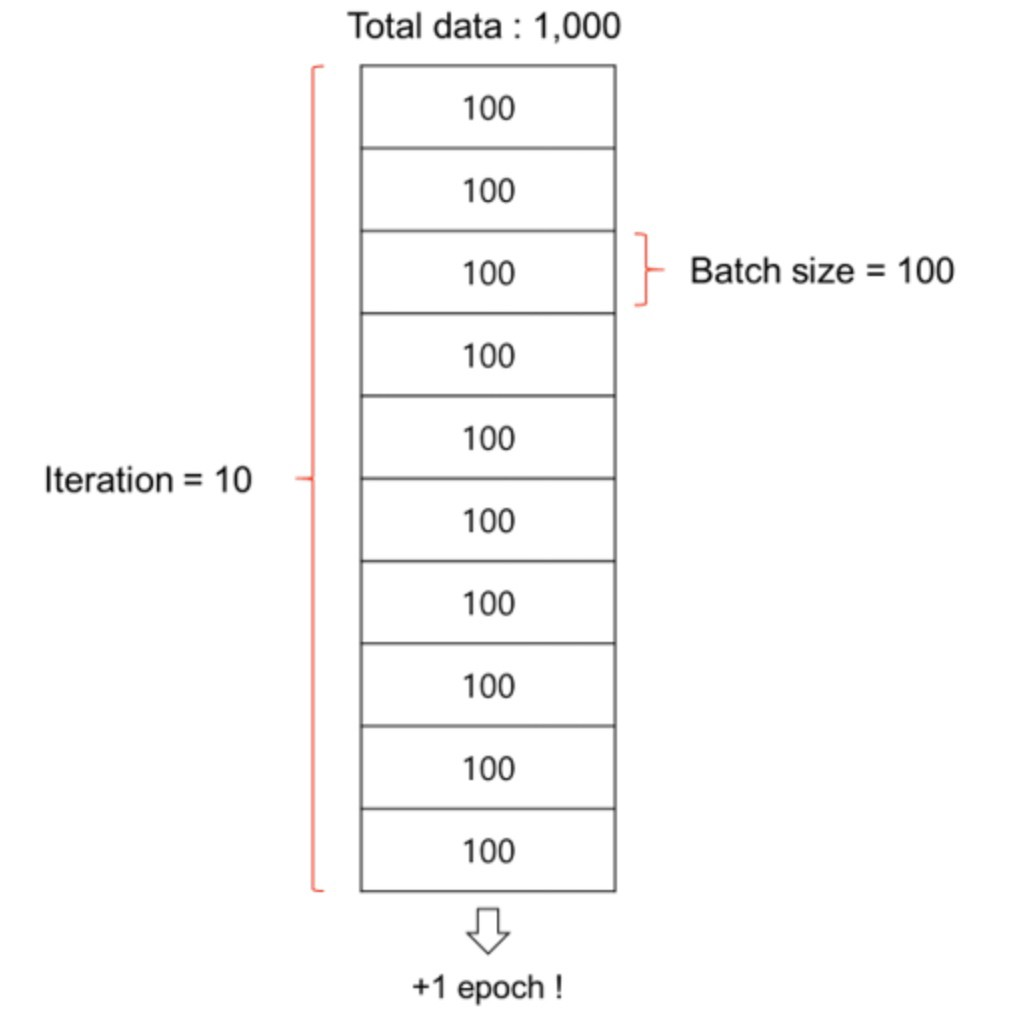

In [4]:
# relation between epoch and iteration
# epoch is the no. of times the whole dataset passed through model for training
# iteration is the no. of times a batch of dataset is passed to model to update the weight
# for stochastic process batch size=1
display.Image('img/5_epoch_iteration.jpeg', width=400)

In [5]:
%%time
# TuneGridSearch 
from sklearn.linear_model import SGDClassifier
from tune_sklearn import TuneGridSearchCV
params = {
    'loss': ['hinge', 'squared_hinge'], 
    'alpha': [1e-4, 1e-1],
    'epsilon': [1e-2, 1e-1]
}

tune_grid_search = TuneGridSearchCV(
    estimator = SGDClassifier(),
    param_grid = params,
    cv = 5,
    early_stopping = True,
    max_iters = 10,
    n_jobs = -1
)

tune_grid_search.fit(X, y)
print("Tune grid search accuracy:", tune_grid_search.best_score)
print("Tune grid search best parameters:", tune_grid_search.best_params_)

Log sync requires rsync to be installed.
(pid=18456) Windows fatal exception: access violation
(pid=18456) 
(pid=2972) Windows fatal exception: access violation
(pid=2972) 
(pid=19940) Windows fatal exception: access violation
(pid=19940) 
(pid=23140) Windows fatal exception: access violation
(pid=23140) 
(pid=5740) Windows fatal exception: access violation
(pid=5740) 
(pid=24788) Windows fatal exception: access violation
(pid=24788) 
(pid=25588) Windows fatal exception: access violation
(pid=25588) 
(pid=13288) Windows fatal exception: access violation
(pid=13288) 


Tune grid search accuracy: 0.72733
Tune grid search best parameters: {'loss': 'hinge', 'alpha': 0.1, 'epsilon': 0.1}
Wall time: 39.3 s


# Bayesian Optimization
- While we already knows how to search over hyperparameters with grid search and random search, where the former one searches over all parameters and the latter one randomly test parameters up to certain number. Sometimes it's better to have something in-between: i.e. searching strategically over parameters without testing all possible values.
- <a href='https://arxiv.org/pdf/1807.02811.pdf'>Bayesian Optimization (BayesOpt, BO)</a> uses probablistic distribution to estimate the objective function to maximize, and adjust the distribution with available values of the function.
- Import <a href='https://docs.ray.io/en/master/tune/api_docs/sklearn.html#tunesearchcv'>TuneSearchCV</a> from tune_sklearn.
- Create a dictionary named <b>param_dists</b>, which define the search space using probability distribution (e.g. uniform, Gaussian, log uniform) of hyperparameters determined by user:
    1. loss: hinge, <a href='https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/squared-hinge'>squared_hinge</a> 
    2. alpha: (1e-4, 1e-1, 'log-uniform'),
    3. epsilon: (1e-2, 1e-1)
    <br><br>
- Call TuneSearchCV, set <b>estimator</b> as before (SGD), <b>param_distributions</b> as parms_dists, 5-fold <b>cross validation</b>, <b>early stopping</b> as True, <b>max number of iteration</b> be 10, <b>search optimization</b> be bayesian, <b>n_jobs</b> be -1 and <b>random state</b> to be 42. 
- Fit TuneSearchCV with X and y.
- Print the best score and best parameters of Bayesian search result using properties <b>best_score</b> and <b>best_params_</b> of TuneSearchCV.

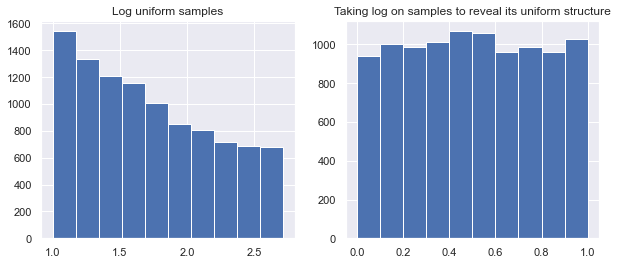

In [6]:
# what is log uniform distribution (visualization)
# meaning the log of the variable is uniform (all outcomes are equally likely)
# best for trying multiplicative parameters (e.g. learning rate) as evenly spaced increment distribution like [0.1, 0.2, 0.3...]
# doesn't make significant change to outcome
def loguniform(low=0, high=1, size=None):
    return np.exp(np.random.uniform(low, high, size))

samples = loguniform(size=10000)
log_samples = np.log(samples)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(samples);
ax[0].set_title('Log uniform samples');
ax[1].hist(log_samples);
ax[1].set_title('Taking log on samples to reveal its uniform structure');

In [7]:
%%time
from tune_sklearn import TuneSearchCV
# use tuples instead if Bayesian optimization is desired
param_dists = {
    'loss': ['hinge', 'squared_hinge'], 
    'alpha': (1e-4, 1e-1, 'log-uniform'),
    'epsilon': (1e-2, 1e-1)                      # default uniform
}

tune_bayesian_search = TuneSearchCV(
    estimator = SGDClassifier(),
    param_distributions = param_dists,
    cv = 5,
    early_stopping = True,
    max_iters = 10,
    search_optimization = "bayesian",
    n_jobs = -1,
    random_state = 42
)

tune_bayesian_search.fit(X, y)
print("Tune Bayesian search accuracy:", tune_bayesian_search.best_score)
print("Tune Bayesian search best parameters:", tune_bayesian_search.best_params_)

(pid=5600) Windows fatal exception: access violation
(pid=5600) 
(pid=18936) Windows fatal exception: access violation
(pid=18936) 
(pid=20592) Windows fatal exception: access violation
(pid=20592) 
(pid=25764) Windows fatal exception: access violation
(pid=25764) 
(pid=22804) Windows fatal exception: access violation
(pid=22804) 
(pid=27036) Windows fatal exception: access violation
(pid=27036) 
(pid=2132) Windows fatal exception: access violation
(pid=2132) 
(pid=24480) Windows fatal exception: access violation
(pid=24480) 


Tune Bayesian search accuracy: 0.72696
Tune Bayesian search best parameters: {'loss': 'hinge', 'alpha': 0.0670818864334629, 'epsilon': 0.06069593960609855}
Wall time: 33.1 s


One can see that the alpha and epsilon of best parameters are float numbers as <b>Bayesian Search allows us to search over a range of numbers governed by a distribution (uniform or log uniform in tune-sklearn)</b>. This cannot be done using grid search for both sklearn and tune-sklearn (though <a href='https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization'>RandomizedSearchCV</a> accepts continuous parameters).

# Compare with sklearn grid search cv
- Apply the same set of estimator and params as part 2 on GridSearchCV of sklearn.
- Print best score and best parameters as well.

In [8]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
sklearn_search = GridSearchCV(
   SGDClassifier(),
   param_grid = params,
   cv=5,
   n_jobs=-1
)
sklearn_search.fit(X, y)
print("Sklearn grid search accuracy:", sklearn_search.best_score_)
print("Sklearn grid search best parameters:", sklearn_search.best_params_)

Sklearn grid search accuracy: 0.7271199999999999
Sklearn grid search best parameters: {'alpha': 0.1, 'epsilon': 0.01, 'loss': 'hinge'}
Wall time: 4min 33s


Sklearn use approximately 5 times duration to serach for best parameters compared with grid search and Bayesian search of tune-sklearn. So in this exercise we explored another library for high efficiency parameter tuning!